# Lab 2 - Signal Analysis for Audio Processing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy import signal
from IPython.display import Audio

%matplotlib inline

First off, let's try to examine an example audio file that was generated from an [online website for metronome sound](https://metronomer.com/noflash.html)!

In [2]:
Audio('tamborine_120bpm.wav')

It should be a simple beat in 4/4 time, at 120 BPM (or 2 Hz)! Now, let's try to load this audio file using Scipy's I/O function - unfortunately it only works on `.wav` format, so if you ever want to try loading another audio file in another format (like `.mp3`), make sure to [convert](https://audio.online-convert.com/convert-to-wav) it into the `.wav` format first!

In [3]:
fs, data = read('tamborine_120bpm.wav')

print('Sampling Frequency: ', fs)
print('Audio Data Size: ', data.shape)

Sampling Frequency:  48000
Audio Data Size:  (721152, 2)


We can see that the sampling frequency is at 48000 Hz - recalling Nyquist's Theorem, this means that we do not have any aliasing problems for signals up to half of the sampling frequency (24000 Hz), which is very much sufficient for the frequencie that we want to look at!

Now, let's try to plot our audio signal waveform for the first 8 beats in the first channel (left side)! This equals to 4 seconds of real time!

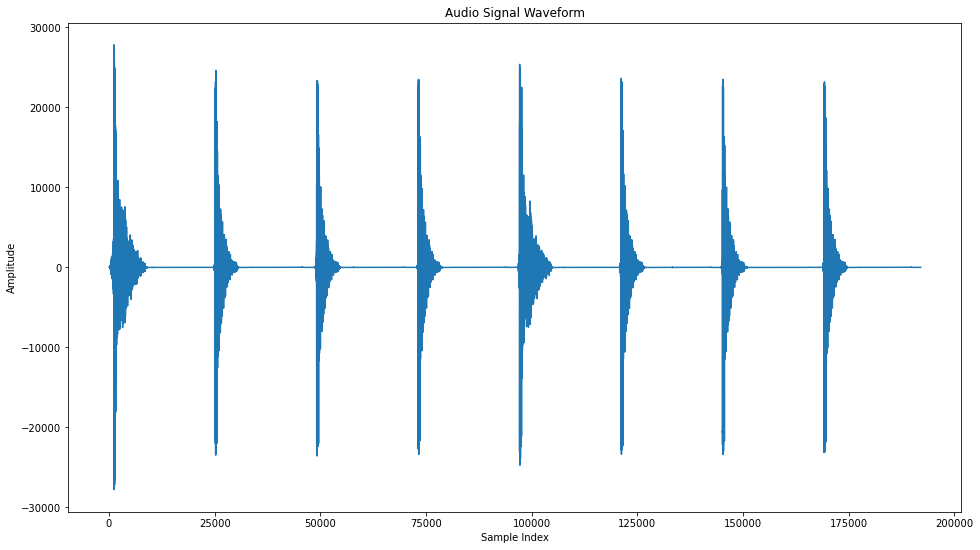

In [4]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

plt.title('Audio Signal Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
ax.plot(data[:(fs*4), 0])

Now, let's take a look at the frequency spectrum of this audio signal! We should be able to see two main groups of FFT peaks - those around the BPM frequency (which should be relatively low), and those around the frequencies of the tamborine noise (which should be relatively high)!

First, let's resample our signal to a lower sampling rate - this would have the effect of losing information on our higher frequency sounds, but we want to focus on the 2 Hz frequency first! If we take 256 samples over 4 seconds (64 Hz), that is a upper frequency bound of 32 Hz for non-aliased signals! In theory, this should still perserve our intended BPM signal!

In [5]:
resampled_data = signal.resample(data[:(fs*4), 0], 256)
resampled_fs = 64

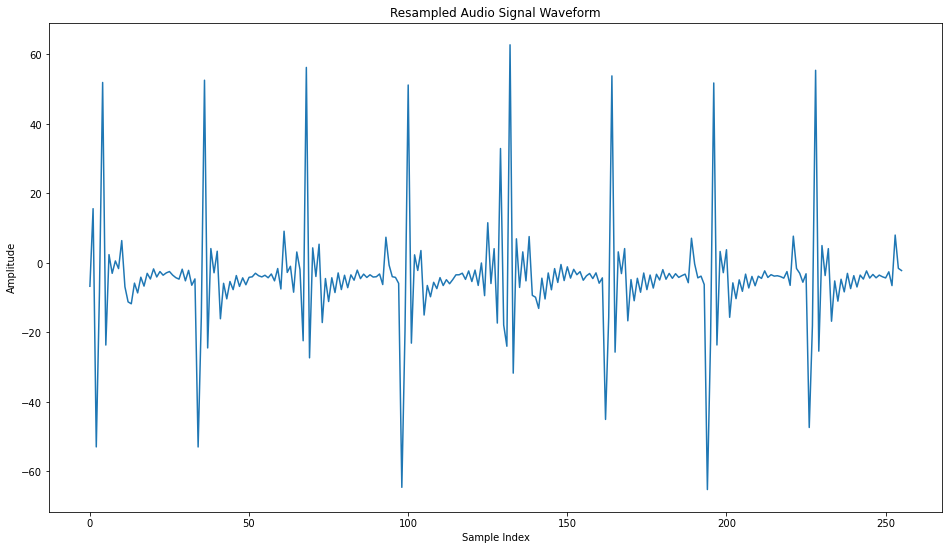

In [6]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

plt.title('Resampled Audio Signal Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
ax.plot(resampled_data)

You can see that the resampled signal has become much coarser, but the BPM is still very clearly shown as the spikes between the resampled signal! Now let's do the FFT on this sample! Make sure that our FFT window size is sufficiently large to cover the signal over enough beats such that that frequency shows up in the FFT!

In [7]:
numFFTBins = 256
fft_data = np.fft.fft(resampled_data, n=numFFTBins)

# Center our FFT spectrum at the zero-frequency component
fft_data = np.fft.fftshift(fft_data)

# Since we get complex values, take its absolute instead
fft_data = np.abs(fft_data)

# Look at only half the shifted FFT plot for the positive frequencies
fft_data = fft_data[:int(numFFTBins/2)]

# Now to get the corresponding frequency values from the FFT
freq = np.fft.fftfreq(numFFTBins, d=1/resampled_fs)
freq = freq[:int(numFFTBins/2)]

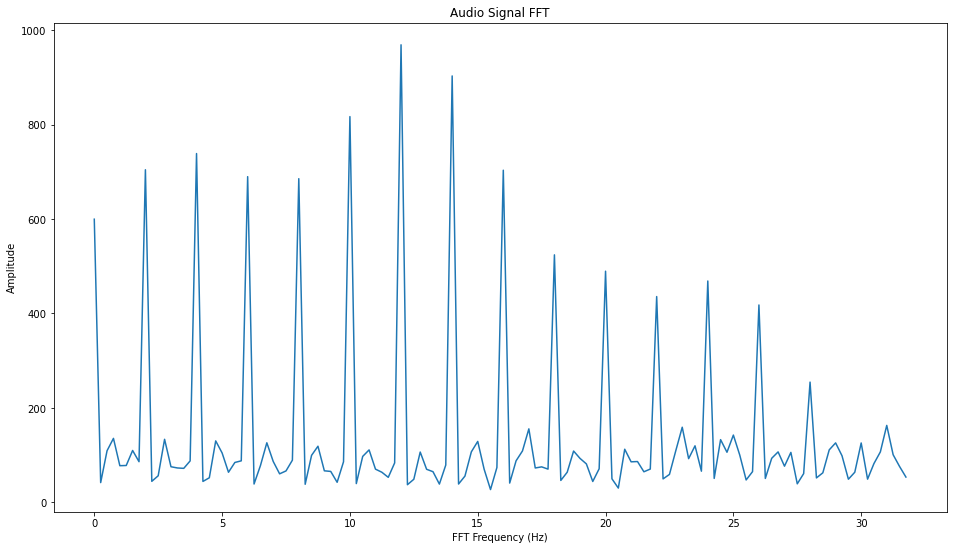

In [8]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

plt.title('Audio Signal FFT')
plt.xlabel('FFT Frequency (Hz)')
plt.ylabel('Amplitude')
ax.plot(freq, fft_data)

That's a lot of peaks! But notice one thing about it - they all appear at regular multiples of 2! This is a limitation of the discrete fourier transform and the signal itself, with higher-frequency aliases "matching" the actual frequency that you want to observe (commonly known as "side lobes"). It is really strong in our case - but let's zoom in and focus on the area of interest, between 0 and 5 Hz!

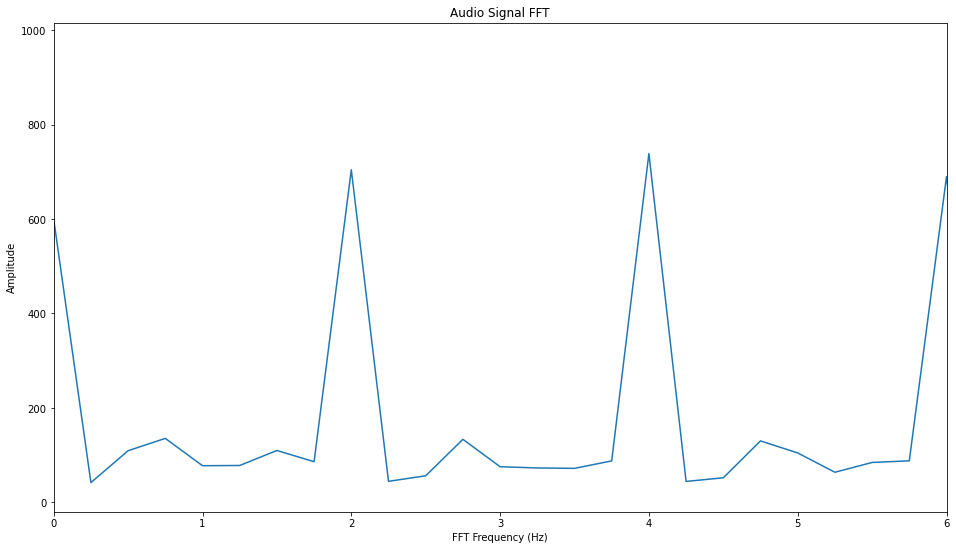

In [9]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

plt.title('Audio Signal FFT')
plt.xlabel('FFT Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim((0, 6))
ax.plot(freq, fft_data)

Our first peak shows up at 2 Hz, and then at 4 Hz! If this is a metronome-setting application, I would pick the lower peak as my BPM, and ignore any peak that might be a multiple of my lowest peak!

There might also be the case that downsampling the signal without trying to reduce higher-frequency components leads to many frequency alias appearing in our FFT plot! This would be a problem when the beats are not as clear as the example audio clip, and you have many sounds occuring throughout!

To address that, let's design and apply a low-pass filter to our original signal first, before downsampling it and looking at the FFT! This is to account for the case of any aliased signals from the higher-frequency sounds bleeding over to the lower frequencies and messing with our FFT plot. Let's assume that we want to have a maximum of 300 BPM (that's 5 Hz), we would want to come up with a transfer function that filters out anything higher than 5 Hz!

## Low Pass Filter Design

We will be using a 3nd order Butterworth Low Pass filter function ([`scipy.signal.butter`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.butter.html)) from Scipy for this! To convert from Hz to rad/s, simply multiply by 2π - 5 Hz would equal to 31.416 rad/s!

In [12]:
b, a = signal.butter(3, 5*2*np.pi, btype='lowpass', analog=True)

Let's take a look at the frequency response of our low-pass filter with the Bode plot:

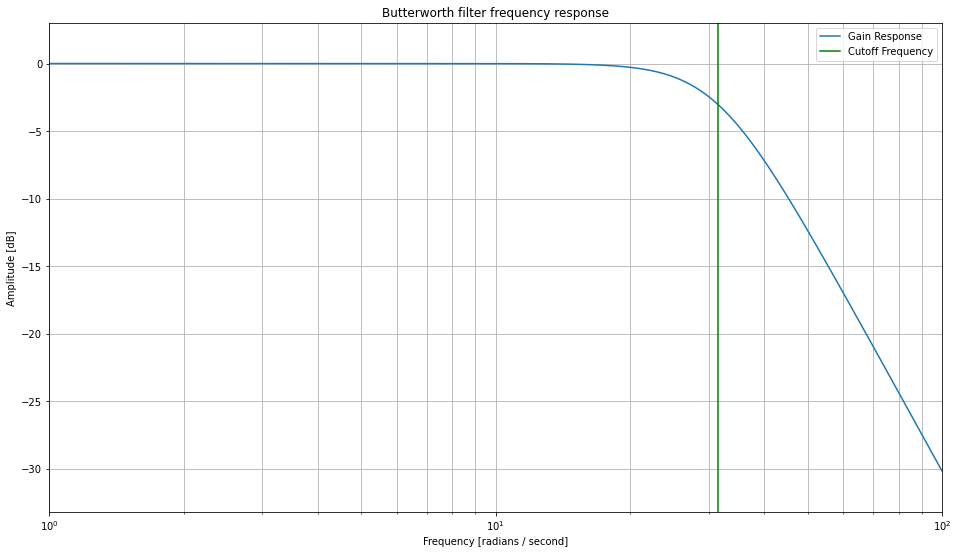

In [13]:
w, h = signal.freqs(b, a)

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
ax.plot(w, 20 * np.log10(abs(h)), label='Gain Response')
plt.xscale('log')
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(5*2*np.pi, color='green', label='Cutoff Frequency')
plt.legend()

With a 3nd order low-pass filter, we have -60 db/dec gain for frequencies past our passband frequency of 5 Hz! In other words, frequency components of **1 order magnitude higher** than the passband frequency will be **1/1000** times less! Now, let's apply it to our original signal and take a look at the waveform!

In [14]:
# However, we need to apply this for a discrete case, so lets set up a discrete Butterworth filter
# We first need to normalize our cutoff frequency to our Nyquist frequency (holf of sampling frequency)
nyquist_freq = fs*np.pi/2
wn = 5*2*np.pi / nyquist_freq

bz, az = signal.butter(2, wn, analog=False)


# We are using the filtfilt function, which applies the filter twice for zero phase change
# This doubles the gain applied overall, meaning our -60db/dec became -120db/dec
# signal_lp = signal.filtfilt(bz, az, data[:(fs*4), 0])

# Or, we can just apply it and keep the phase difference
signal_lp = signal.lfilter(bz, az, data[:(fs*4), 0])

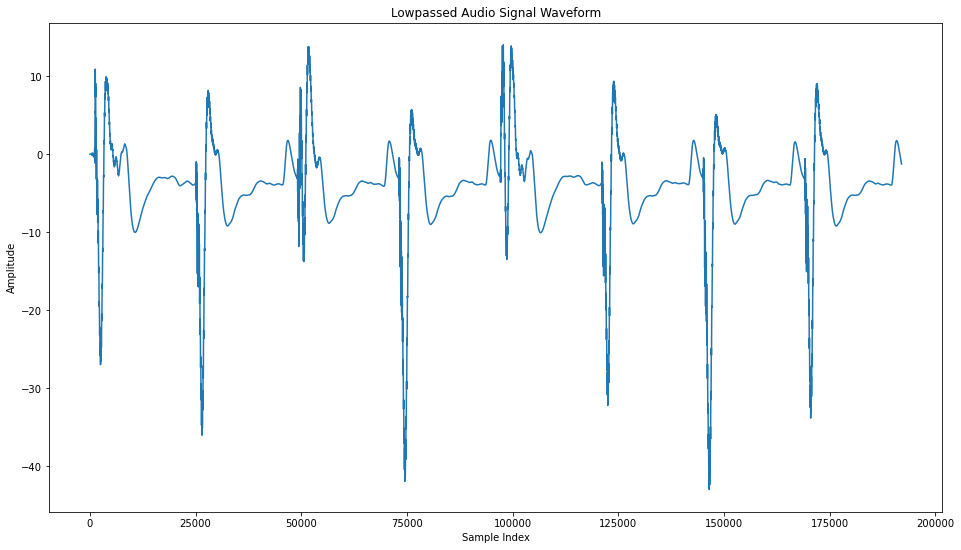

In [15]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
plt.title('Lowpassed Audio Signal Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
ax.plot(signal_lp)

Our low-passed audio signal looks a lot "smoother"! You can try it out with other audio examples with more noises in the background and observe the effect of our low-pass filter!

Now, let's downsample it again and look at its FFT!

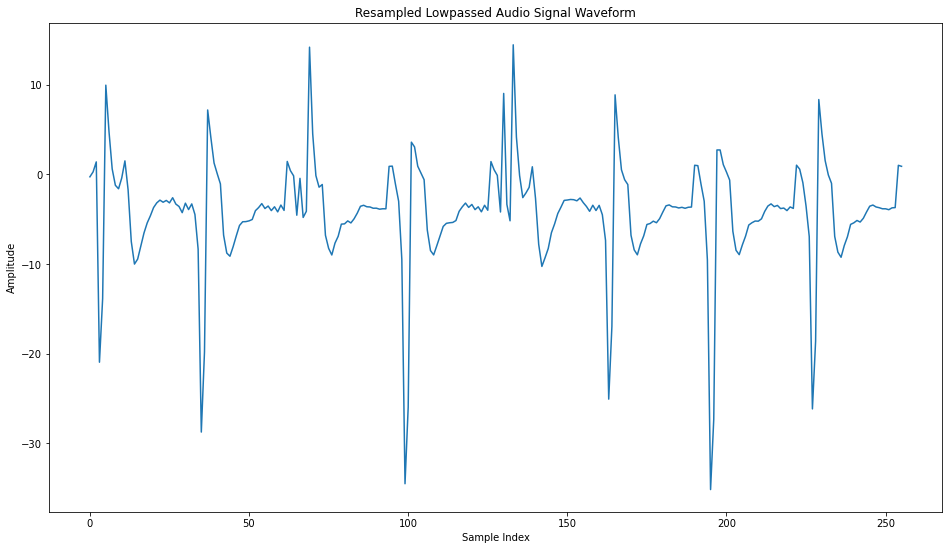

In [17]:
resampled_data = signal.resample(signal_lp, 256)
resampled_fs = 64

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

plt.title('Resampled Lowpassed Audio Signal Waveform')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
ax.plot(resampled_data)

The downsample version looks pretty much the same as the original signal this time - this is because we've filtered our signal to be lower than the Nyquist frequency!

In [18]:
numFFTBins = 256
fft_data = np.fft.fft(resampled_data, n=numFFTBins)

# Center our FFT spectrum at the zero-frequency component
fft_data = np.fft.fftshift(fft_data)

# Since we get complex values, take its absolute instead
fft_data = np.abs(fft_data)

# Look at only half the shifted FFT plot for the positive frequencies
fft_data = fft_data[:int(numFFTBins/2)]

# Now to get the corresponding frequency values from the FFT
freq = np.fft.fftfreq(numFFTBins, d=1/resampled_fs)
freq = freq[:int(numFFTBins/2)]

(0.0, 6.0)

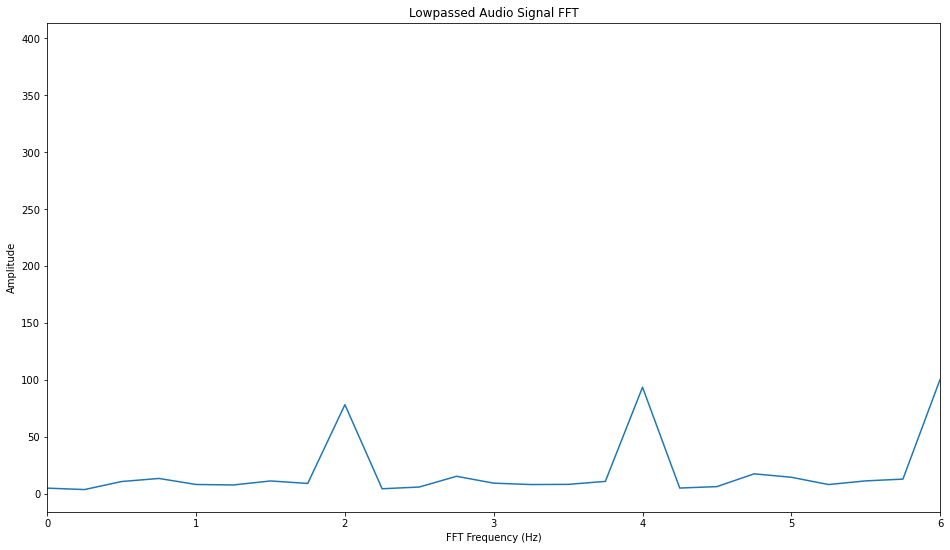

In [19]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()

plt.title('Lowpassed Audio Signal FFT')
plt.xlabel('FFT Frequency (Hz)')
plt.ylabel('Amplitude')
ax.plot(freq, fft_data)
plt.xlim((0,6))

We still see the side-lobes appearing at multiples of 2 Hz! But this is a good place to stop, since the idea of this section was to mainly to try and apply a low-pass filter to our audio signal.

Most BPM detection algorithm rely more on identifying amplitude peak in a narrow bandpass of signals (looking for frequencies typical for drums, claps, etc.), and simply taking a windowed average of the intervals between those peaks for your BPM. This is likely more reliable than the FFT approach, since the frequency spectrum shown by the FFT would probably be cluttered with many components at once.

## Exercise - Finding BPM by peak detection and bandpass filtering

Now, try running this example for your own audio file! See if you can see the actual BPM by FFT analysis - identify any other shortcoming of this approach! See if you can implement an alternative approach to finding the BPM of your audio signal!